In [1]:
import os, sys
import numpy as np
import cv2
import glob
import pickle
import copy
import skimage
import matplotlib.pyplot as plt
%matplotlib qt
%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

In [ ]:
# Computing Camera Matrix and Distortion Coefficients
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
# Z-coord is 0 for all the points
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    # print(corners)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        write_name = 'corners_found'+str(idx)+'.jpg'
        write_name = os.path.join('results', write_name)
        cv2.imwrite(write_name, img)

        
# We have objpoints and imgpoints needed for camera calibration
# and computation of distortion coefficients
def calibrate_undistort(img, objpoints, imgpoints):
    img_size = (img.shape[1], img.shape[0])
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('results/test_image_undist.jpg',dst)

    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    dist_pickle["objpoints"] = objpoints
    dist_pickle["imgpoints"] = imgpoints
    pickle.dump( dist_pickle, open( "results/wide_dist_pickle.p", "wb" ) )
    return dst

# Test undistortion on an image
image = cv2.imread('test_images/test2.jpg')
# convert to RGB for display purpose
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted = calibrate_undistort(image, objpoints, imgpoints)

In [2]:
class ImageProcessing(object):    
    @staticmethod
    def undistort(img, mtx, dist):
        img_size = (img.shape[1], img.shape[0])
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        return undist
    
    @staticmethod
    def clahe_rgb(img):
        img_clahe = np.copy(img)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img_clahe[:,:,0] = clahe.apply(img[:,:,0])
        img_clahe[:,:,1] = clahe.apply(img[:,:,1])
        img_clahe[:,:,2] = clahe.apply(img[:,:,2])
        return img_clahe        
    
    @staticmethod
    def s_channel_thresh(img, thresh=(0, 255)):
        '''
        Define a function that thresholds the S-channel of HLS
        '''
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        #print 's_channel = ',np.min(s_channel), np.max(s_channel)
        binary_output = np.zeros_like(s_channel)
        binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 255
        return binary_output    

    @staticmethod
    def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Apply x or y gradient with the OpenCV Sobel() function
        # and take the absolute value
        if orient == 'x':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
        if orient == 'y':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        # Rescale back to 8 bit integer
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        # Create a copy and apply the threshold
        binary_output = np.zeros_like(scaled_sobel)
        # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
        thresh_min = thresh[0]
        thresh_max = thresh[1]
        binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 255
        # Return the result
        return binary_output

    @staticmethod
    def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
        '''
        Define a function to return the magnitude of the gradient
        for a given sobel kernel size and threshold values
        '''
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Take both Sobel x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Calculate the gradient magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        # Rescale back to 8 bit integer
        gradmag = np.uint8(255*gradmag/np.max(gradmag))
        # Create a binary image of ones where threshold is met, zeros otherwise
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 255
        # Return the binary image
        return binary_output

    @staticmethod
    def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
        '''
        Define a function to threshold an image for a given range and Sobel kernel
        '''
        # Grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Calculate the x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Take the absolute value of the gradient direction, 
        # apply a threshold, and create a binary image result
        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        binary_output =  np.zeros_like(absgraddir)
        binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 255
        # Return the binary image
        return binary_output

    @staticmethod
    def create_mask(img, vertices):
        """
        Only keeps the region of the image defined by the polygon
        formed from `vertices`. The rest of the image is set to black.
        """
        vertices = np.array(vertices, dtype=np.int32)

        #defining a blank mask to start with
        mask = np.zeros_like(img)   

        #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255        
        #filling pixels inside the polygon defined by "vertices" with the fill color    
        cv2.fillPoly(mask, vertices, ignore_mask_color)    
        #returning the image only where mask pixels are nonzero
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image

    @staticmethod
    def compute_warp_coords(image):
        # find region of interest
        ysize = image.shape[0]
        xsize = image.shape[1]
        xcenter = xsize/2
        xoffset = 90
        xcenteroffset = 90
        src = np.array([[(xoffset,ysize), (xcenter-xcenteroffset+20, 450), 
                         (xcenter+xcenteroffset, 450), (xsize-xoffset,ysize)]], 
                         dtype=np.float32)

        dst = np.array([[(xoffset,ysize), (xoffset,0), 
                         (xsize-xoffset, 0), (xsize-xoffset,ysize)]], 
                         dtype=np.float32) 
    #     dst = np.array([[(xoffset,xsize), (xoffset,0),
    #                     (ysize-xoffset, 0),(ysize-xoffset,xsize)]],
    #                     dtype=np.float32)    
        return src, dst

    @staticmethod
    def draw_lines(img, vertices):
        img_copy = img.copy()
        pts= np.int32([vertices])
        cv2.polylines(img_copy, pts, True, (0,0,255), thickness=3)
        return img_copy

    @staticmethod
    def compute_perspective(src, dst, inv=False):
        '''
        Compute Perspective Transformation, given source and destination coordinates
        '''
        M = cv2.getPerspectiveTransform(src, dst)
        Minv = None
        if inv:
            Minv = cv2.getPerspectiveTransform(dst, src)    
        return M, Minv
    
    @staticmethod
    def plot2(im1, im2, name1, name2, cmap1=None, cmap2=None, write=None):
        # Visualize undistortion
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))                
        if cmap1:
            ax1.imshow(im1, cmap=cmap1)
        else:
            ax1.imshow(im1)
        ax1.set_title(name1, fontsize=20)
        if cmap2:
            ax2.imshow(im2, cmap=cmap2)
        else:
            ax2.imshow(im2)
        ax2.set_title(name2, fontsize=20)
        
        if write:
            f.savefig(write)
        

In [3]:
# Define a class to receive the characteristics of each line detection
class LanesPerFrame():
    def __init__(self):
        # Define conversions in x and y from pixels space to meters
        self.ym_per_pix = 30.0/720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    
    def reset(self):
        self.xOffset = None
        self.leftx = None
        self.lefty = None
        self.rightx = None
        self.righty = None
        self.left_fit = None
        self.right_fit = None
        self.left_fitx = None
        self.right_fitx = None
        self.left_curverad = None
        self.right_curverad = None
        
    def compute_startpoint(self, binary_warped):
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)    
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines    
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        return leftx_base, rightx_base
    
    def compute_nonzero_pixels(self, binary_warped):
        '''
        Identify the x and y positions of all nonzero pixels in the image
        '''        
        nonzero = binary_warped.nonzero()  
        return nonzero
    
    def compute_lineindices_using_window(self, binary_warped, nonzero, base_pts):
        # Choose the number of sliding windows
        nwindows = 9
        # Set the width of the windows +/- margin
        margin = 120
        # Set minimum number of pixels found to recenter window
        minpix = 75
        
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)

        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Current positions to be updated for each window
        leftx_current = base_pts[0]
        rightx_current = base_pts[1]

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # image dimension
        x_high = binary_warped.shape[1]
        y_high = binary_warped.shape[0]    
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            
            # Draw the windows on the visualization image
            #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    #             print 'leftx_current = ',leftx_current
            if len(good_right_inds) > minpix:
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    #             print 'rightx_current = ',rightx_current

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        return left_lane_inds, right_lane_inds
    
    def compute_lineindices_using_prevframe(self, PreviousLanes, nonzero):
        margin = 120
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        left_fit = PreviousLanes.left_fit
        right_fit = PreviousLanes.right_fit
        
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
        return left_lane_inds, right_lane_inds
        
    def compute_linepixels(self, nonzero, lane_indices):
        # Extract left and right line pixel positions
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        left_lane_inds = lane_indices[0]
        right_lane_inds = lane_indices[1]
        
        self.leftx = nonzerox[left_lane_inds]
        self.lefty = nonzeroy[left_lane_inds] 
        self.rightx = nonzerox[right_lane_inds]
        self.righty = nonzeroy[right_lane_inds] 

    def fit_poly(self):
        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(self.lefty, self.leftx, 2)
        self.right_fit = np.polyfit(self.righty, self.rightx, 2)

    def transform_to_orig_space(self, binary_warped, undistorted, Minv):
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([self.left_fitx, self.ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([self.right_fitx, self.ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))        
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
        return result
    
    def find_curvature(self, yvals, fitx):
        # Define y-value where we want radius of curvature
        # I'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.mean(yvals)
        fit_cr = np.polyfit(yvals*self.ym_per_pix, fitx*self.xm_per_pix, 2)
        curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5)/np.absolute(2*fit_cr[0])
        return curverad    

    def compute_curvature_both_lines(self):
        #self.ploty = np.linspace(0, 100, num=101)*7.2
        self.ploty = np.linspace(0, binary_warped.shape[0]-1, num= binary_warped.shape[0])
        self.left_fitx = self.left_fit[0]*self.ploty**2 + self.left_fit[1]*self.ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*self.ploty**2 + self.right_fit[1]*self.ploty + self.right_fit[2]
        
        self.left_curverad  = self.find_curvature(self.ploty, self.left_fitx)
        self.right_curverad = self.find_curvature(self.ploty, self.right_fitx)

    def compute_position_from_center(self, binary_warped):
        '''
        You can assume the camera is mounted at the center of the car, such that the lane center 
        is the midpoint at the bottom of the image between the two lines you've detected. 
        The offset of the lane center from the center of the image (converted from pixels to meters) 
        is your distance from the center of the lane.
        '''
        xLeft = self.left_fitx[0]
        xRight = self.right_fitx[0]
        xMid = binary_warped.shape[1]*0.5
        xOffset = (xRight - xMid) - (xMid - xLeft)
        # in meters
        self.xOffset = xOffset * self.xm_per_pix        


In [4]:
class SanitizeLanes(object):
    def __init__(self):
        # measurement in meters
        self.ACTUAL_RADIUS_OF_CURVATURE = 1000
        self.MEAN_X_SHIFT_BETWEEN_FRAMES = 25
        
    def closeby(self, val1, val2, eps=0.25):
        diff = ((abs(val1-val2)*1.0)/val1)
        if diff>eps:
            return False        
        return True
    
    def ratio(self, r1, r2):
        if r1>=r2:
            return r1*1.0/r2
        return r2*1.0/r1
    
    def check_curvature(self, current_curverad, previous_curverad):
        if not self.closeby(self.ACTUAL_RADIUS_OF_CURVATURE, current_curverad, 0.5):
            return False

        if not self.closeby(current_curverad, previous_curverad, 0.5):
            return False

        ratio_curverad = self.ratio(current_curverad, previous_curverad)        
        if not ratio_curverad < 100:
            return False        
        return True
    
    def closeby_lanes(self, left_curverad, right_curverad):
        if not self.closeby(left_curverad, right_curverad, 0.5):
            return False
        return True

    def check_lanepixels(self, current_fitx, previous_fitx):        
        diff_fitx = abs(np.mean(current_fitx) - np.mean(previous_fitx))
        if not diff_fitx <= self.MEAN_X_SHIFT_BETWEEN_FRAMES:
            return False        
        return True

def copyFromPrevLane(CurrentLanes, PreviousLanes, _copy):
    newLanes = copy.deepcopy(CurrentLanes)
    if _copy=='left':
        newLanes.leftx = PreviousLanes.leftx
        newLanes.lefty = PreviousLanes.lefty
        newLanes.left_fit = PreviousLanes.left_fit
        newLanes.left_fitx = PreviousLanes.left_fitx
        newLanes.left_curverad = PreviousLanes.left_curverad
    elif _copy=='right':
        newLanes.rightx = PreviousLanes.rightx
        newLanes.righty = PreviousLanes.righty
        newLanes.right_fit = PreviousLanes.right_fit
        newLanes.right_fitx = PreviousLanes.right_fitx
        newLanes.right_curverad = PreviousLanes.right_curverad
    return newLanes


In [5]:
def load_test_video(file_name='project_video.mp4'):
    images = []
    d = {'count' : 0}
    
    def convert_frame(img):
#         img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        f="%s - %d" % (file_name, d['count'])
        d['count'] += 1
        return (f,img)
    
    clip = VideoFileClip(file_name)
    images = [convert_frame(frame) for frame in clip.iter_frames(progress_bar=True)]    
    return images

# load images from projet video provided
images = load_test_video()

100%|█████████▉| 1260/1261 [00:08<00:00, 144.55it/s]


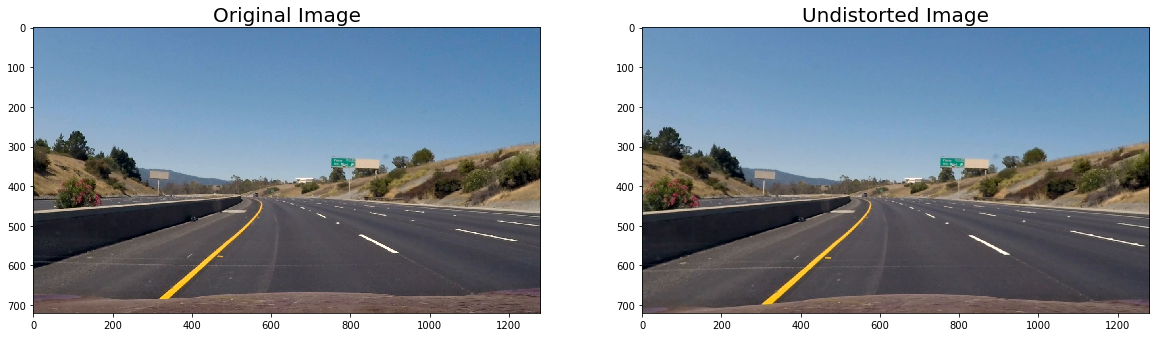

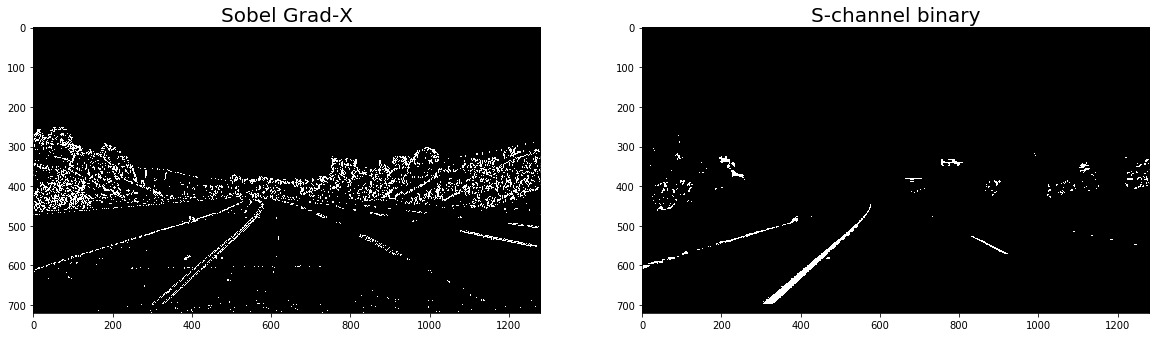

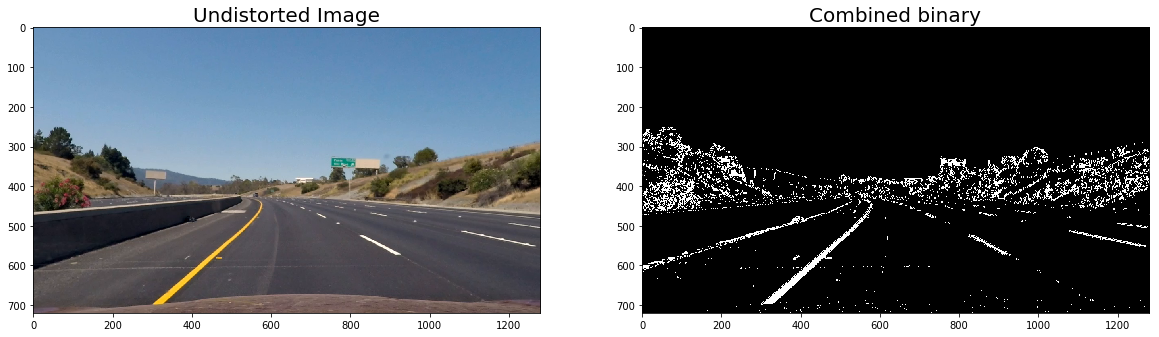

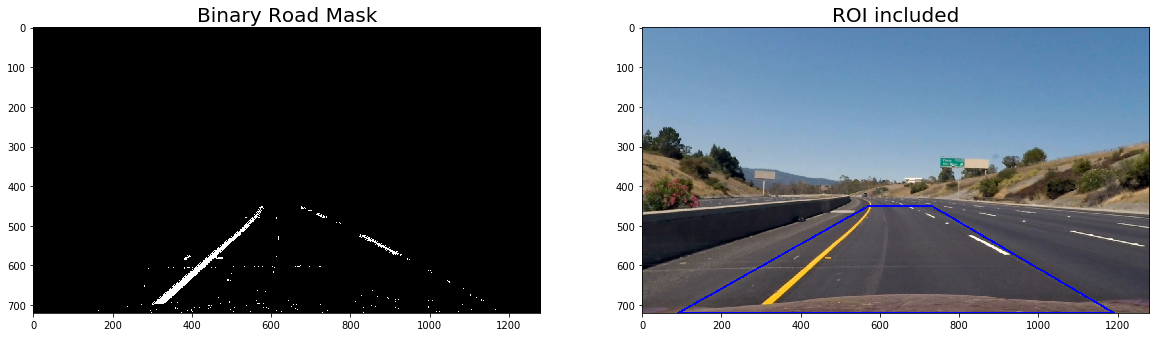

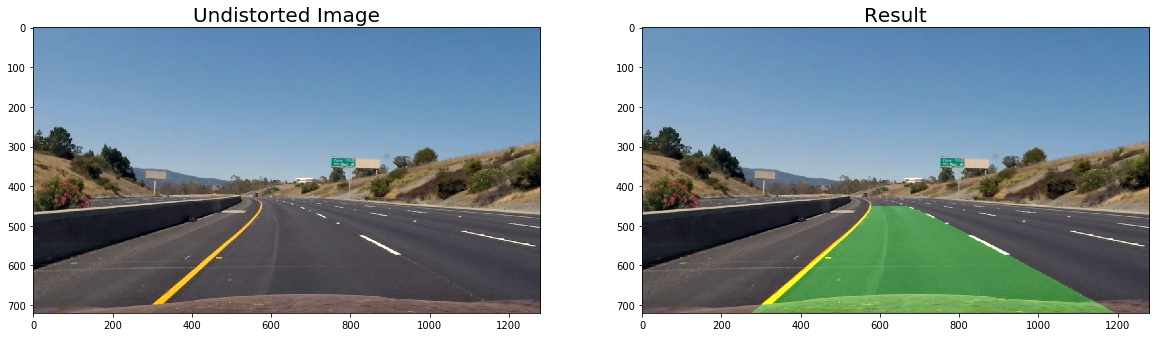

In [6]:
# process images in the project video, frame by frame
dist_pickle = pickle.load(open("results/wide_dist_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Initialize Lane lines
PreviousLanes = None
CurrentLanes = LanesPerFrame()
LaneSanitizer = SanitizeLanes()

LANE_LOST_COUNT = 0
for idx,image in enumerate(images):
    # reset Lanes for this frame
    CurrentLanes.reset()
        
    # undistort the RGB image
    image = image[1]
    undistorted = ImageProcessing.undistort(image, mtx, dist)
    ImageProcessing.plot2(image, undistorted, 'Original Image', 'Undistorted Image', write='image1.png')
    
    # adaptive histogram equalization
    # undistorted = ImageProcessing.clahe_rgb(undistorted)

    # compte edges using various transformations
    gradx = ImageProcessing.abs_sobel_thresh(undistorted, orient='x', sobel_kernel=3, thresh=(20, 100))
    hls_binary = ImageProcessing.s_channel_thresh(undistorted, thresh=(150, 255))
    ImageProcessing.plot2(gradx, hls_binary, 'Sobel Grad-X', 'S-channel binary', 'gray', 'gray', write='image2.png')

    # prepare a combined binary image from above transformations
    combined = np.zeros_like(gradx, dtype=np.uint8)
    combined[(gradx == 255) | (hls_binary == 255)] = 255
    ImageProcessing.plot2(undistorted, combined, 'Undistorted Image', 'Combined binary', None, 'gray', write='image3.png')
    
    # compute src and dst points for perspective transformation
    src_pts, dst_pts = ImageProcessing.compute_warp_coords(combined)
    
    # prepare mask containing lane only: ROI
    masked_edges = ImageProcessing.create_mask(combined, src_pts)
    
    # compute perspective transform (forward & backward both)
    M, Minv = ImageProcessing.compute_perspective(src_pts, dst_pts, True)
    undistorted_display = ImageProcessing.draw_lines(undistorted,src_pts)
    ImageProcessing.plot2(masked_edges, undistorted_display, 'Binary Road Mask', 'ROI included', 'gray', None, write='image4.png')
        
    # Apply perspective transform on undistorted image
    binary_warped = cv2.warpPerspective(masked_edges, M, (masked_edges.shape[1], masked_edges.shape[0]))
    
    nonzero = CurrentLanes.compute_nonzero_pixels(binary_warped)

    # Compute lanes using windows only when either lane LOST or no past frame info available
    if not PreviousLanes:
        base_pts = CurrentLanes.compute_startpoint(binary_warped)    
        line_indices = CurrentLanes.compute_lineindices_using_window(binary_warped, nonzero, base_pts)
    else:
        line_indices = CurrentLanes.compute_lineindices_using_prevframe(PreviousLanes, nonzero)
    
    CurrentLanes.compute_linepixels(nonzero, line_indices)    
    CurrentLanes.fit_poly()    
    CurrentLanes.compute_curvature_both_lines()    
    
    # perform sanity checks, before accepting results
    accept_left_lanes = True
    accept_right_lanes = True
    if PreviousLanes:
        if not LaneSanitizer.check_curvature(CurrentLanes.left_curverad, PreviousLanes.left_curverad):
            accept_left_lanes = False
        if not LaneSanitizer.check_curvature(CurrentLanes.right_curverad, PreviousLanes.right_curverad):
            accept_right_lanes = False
        if not LaneSanitizer.check_lanepixels(CurrentLanes.left_fitx, PreviousLanes.left_fitx):
            accept_left_lanes = False
        if not LaneSanitizer.check_lanepixels(CurrentLanes.right_fitx, PreviousLanes.right_fitx):
            accept_right_lanes = False
        if not LaneSanitizer.closeby_lanes(CurrentLanes.left_curverad, CurrentLanes.right_curverad):
            accept_left_lanes = False
            accept_right_lanes = False

    # If CurrentLanes passed all the sanity checks, show the result
    if LANE_LOST_COUNT < 5:
        if (not accept_left_lanes) and (not accept_right_lanes):                
            CurrentLanes = copy.deepcopy(PreviousLanes)
            LANE_LOST_COUNT += 1
        elif accept_left_lanes and (not accept_right_lanes):
            CurrentLanes = copyFromPrevLane(CurrentLanes, PreviousLanes, 'right')
            LANE_LOST_COUNT += 1
        elif accept_right_lanes and (not accept_left_lanes):
            CurrentLanes = copyFromPrevLane(CurrentLanes, PreviousLanes, 'left')
            LANE_LOST_COUNT += 1
    else:
        # do a full scan to find both lanes using windows again
        line_indices = CurrentLanes.compute_lineindices_using_window(binary_warped, nonzero, base_pts)
        CurrentLanes.compute_linepixels(nonzero, line_indices)    
        CurrentLanes.fit_poly()
        CurrentLanes.compute_curvature_both_lines()                
        LANE_LOST_COUNT = 0
    
    # Compute offset from center
    CurrentLanes.compute_position_from_center(binary_warped)
    
    # Transform CurrentLanes to original world space
    result = CurrentLanes.transform_to_orig_space(binary_warped, undistorted, Minv)        
    ImageProcessing.plot2(undistorted, result, 'Undistorted Image', 'Result', write='image5.png')
    
    fname = os.path.join('project_video_results', str(idx) + '.jpg')
    cv2.imwrite(fname, result)
    
    # if all good, add current results to be used in next iteration
    PreviousLanes = copy.deepcopy(CurrentLanes)
    
    break
#     if idx>=320:
#         break